# <font size = 5>Setting up</font>

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
import pandas as pd
from qutip import *
import scipy.constants
import pickle
from tkinter import filedialog # for prompting user to set analysis folder
import glob
import h5py
from pathlib import PureWindowsPath, PurePosixPath
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from sympy.physics.wigner import wigner_3j, wigner_6j
from scipy.integrate import quad


analysis_directory = '/Users/huanbui/Documents/GitHub/labscript-suite/userlib/analysislib/common/analysis_scripts'
sys.path.append(analysis_directory)

image_utils_directory = '/Users/huanbui/Documents/GitHub/labscript-suite/userlib/analysislib/common/image_utils'
sys.path.append(image_utils_directory)

from analysis_utility_functions import *
from analysis_ROI_finding_functions import *
from analysis_functions import *

In [5]:
# suppress warnings: do at your own risk!
import warnings
warnings.filterwarnings("ignore")

In [6]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
c = 299792458 # m/s
h_planck = hbar*2*np.pi  # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
muB_cm1_G = muB / (100*c*h_planck*1e4) # Bohr magneton in units of cm-1 per Gauss
a0 = 5.2917720859e-11    # Bohr radius
muN = scipy.constants.physical_constants['nuclear magneton'][0]
eps0 = scipy.constants.epsilon_0
gS = 2.0023193043622
kB = 1.380649e-23 # Boltzmann constant
DebyeSI = 3.33564e-30

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e-25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034

# NaK constants:
mK41 = 6.80187059497004e-26 # kg
mK40 = 6.63617749148248e-26 # kg
mK39 = 6.47007514485677e-26 # kg
u = 1.660538782e-27  # kg
Eh = 4.35974394e-18 
RKRcst = hbar/np.sqrt(2*u) * (10**10) * np.sqrt(1/(100 * c * hbar * 2*np.pi)) 
muNa39K = (mNa23 * mK39)/(mNa23 + mK39) * 1/u # atomic units
muNa40K = (mNa23 * mK40)/(mNa23 + mK40) * 1/u # atomic units 
muNa41K = (mNa23 * mK41)/(mNa23 + mK41) * 1/u # atomic units

# <font size = 5>Model Integrals</font>

In [48]:
def imaginary_integrand(P, En, a_scat, beta):
    s = En + 0.0025j + P**2
    Eb = np.heaviside(a_scat, 0)/(2 * a_scat**2)
    return -4*np.pi*(P**2)*np.exp(-beta * P**2) * np.sqrt(s)/ (s + Eb)

def real_integrand(P, En, a_scat, beta):
    s = En + 0.0025j + P**2
    return (P**2)*np.exp(-beta * P**2) / (1/a_scat - np.sqrt(-s))

In [55]:
points = 300
momentum_cutoff = 20
En = np.linspace(-100,100,points)
a_scat = 0.13
beta = 0.1
z = 0.1
imaginary_results = []*points
real_results = []*points
for i in range(points):
    real_results.append(z*quad(real_integrand, 0, momentum_cutoff, args=(En[i], a_scat, beta), epsrel=1e-16, limit=200)[0])
    imaginary_results.append(z*quad(imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat, beta), epsrel= 1e-16, limit=200)[0])

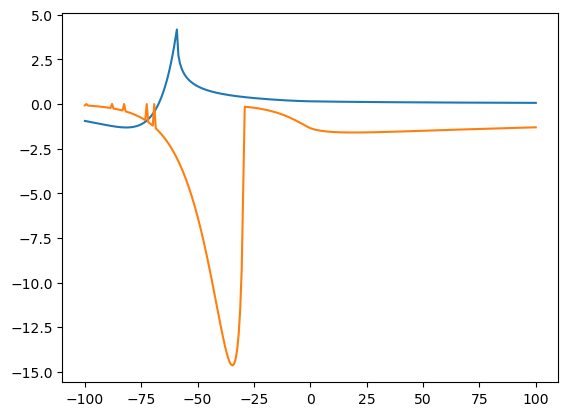

In [56]:
plt.plot(En, real_results)
plt.plot(En, imaginary_results)

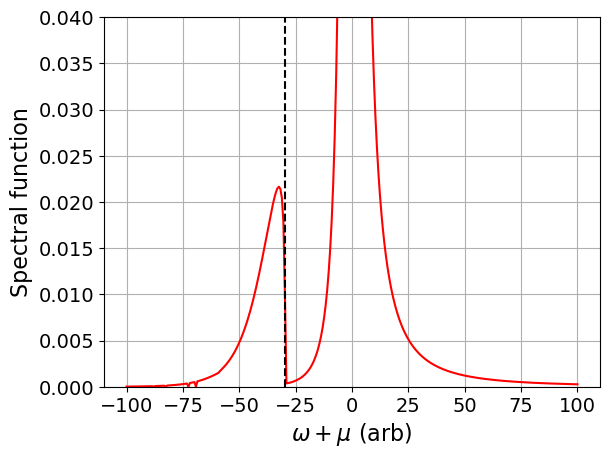

In [57]:
# spectral function?
A =  -2* np.array(imaginary_results)/( (En - np.array(real_results))**2 + np.array(imaginary_results)**2)
plt.plot(En,A, color = 'red')
plt.ylim([0,0.04])
plt.vlines(x = -1/(2 * a_scat**2), ymin = 0, ymax = np.max(A), color = 'black', linestyles='--')
plt.grid()
plt.xlabel('$\omega + \mu$ (arb)', fontsize = 16)
plt.ylabel('Spectral function', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

# <font size = 5>Same integrals, but with lab values?</font>

In [268]:
def NaK_imaginary_integrand(P, En, a_scat, beta, k):
    Eb = np.heaviside(a_scat, 0) * (hbar**2/(2 * a_scat**2 * muNa40K * u)) / h_planck # in Hz
    s = En + 10j - (mNa23 + mK40)*(P**2/(2*mNa23 + 2*mK40) - (P-k)**2/(2*mNa23)) # in Hz
    factor = (-4*np.pi / (2*np.pi)**3) * (mNa23 + mK40)**(3/2)
    T_matrix = (2*np.sqrt(2) / (muNa40K * u)**(3/2)) * np.sqrt(s)/ (s + Eb)
    return factor * (P**2) * np.exp(-beta * (mNa23 + mK40) * (P-k)**2/ (2 * mNa23)) * T_matrix

def NaK_real_integrand(P, En, a_scat, beta, k):
    Eb = np.heaviside(a_scat, 0)*(hbar**2/(2 * a_scat**2 * muNa40K * u)) / h_planck # in Hz
    s = En + 10j - ( mNa23 + mK40)*(P**2/(2*mNa23 + 2*mK40) - (P-k)**2/(2*mNa23) ) # in Hz
    factor = ((4 * np.pi) / (2*np.pi)**3 ) * (mNa23 + mK40)**(3/2)
    T_matrix = (2 * np.pi / (np.sqrt(2) * (muNa40K * u)**(3/2)) ) / (np.sign(a_scat)*np.sqrt(Eb) - np.sqrt(-s))
    return factor * (P**2) * np.exp(-beta * (mNa23 + mK40) * (P-k)**2/  (2 * mNa23)) * T_matrix

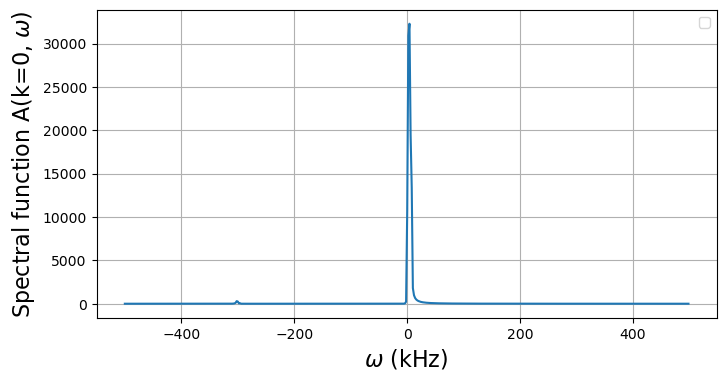

In [345]:
# temperature dependence?
dk = 1e1
dEn = 2e3
k_list = np.arange(0,1e2, dk)
ek = (hbar**2 * k**2 / (2 * muNa40K * u) ) / h_planck   # in Hz
momentum_cutoff = 3e3
T = 200e-9
a_scat_initial = -1700 * a0
a_scat_final = 640 * a0
En = np.arange(-500e3,500e3,dEn)
points = len(En)
z = 0.2 # n * Lambda^3
beta = h_planck / (kB * T) 

fig, ax = plt.subplots(figsize = (8,4))
A_conv = np.zeros(points)
# initial state
for k in k_list:
    # imaginary_results_initial = []*points
    # real_results_initial = []*points
    # for i in range(points):
    #     real_results_initial.append(z*quad(NaK_real_integrand, 0, momentum_cutoff, args=(En[i], a_scat_initial, beta, k), epsabs=1e-6)[0])
    #     imaginary_results_initial.append(z*quad(NaK_imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat_initial, beta, k), epsabs=1e-6)[0])
    # A_initial = -2*np.array(imaginary_results_initial)/( (En - k**2 + np.array(real_results_initial))**2 + np.array(imaginary_results_initial)**2)
    # ax.plot(En*1e-3, A_initial, linewidth = 1.5, color = 'red', label='initial')
    # ######

    # final state
    imaginary_results_final = []*points
    real_results_final = []*points
    for i in range(points):
        real_results_final.append(z*quad(NaK_real_integrand, 0, momentum_cutoff, args=(En[i], a_scat_final, beta, k), epsabs=1e-6)[0])
        imaginary_results_final.append(z*quad(NaK_imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat_final, beta, k), epsabs=1e-6)[0])
    A_final = -2*np.array(imaginary_results_final)/( (En - k**2 + np.array(real_results_final))**2 + np.array(imaginary_results_final)**2)
    A_final = A_final / np.linalg.norm(A_final)
    # ax.plot(En*1e-3, dk * k**2 * A_final * np.exp(-beta * k**2), linewidth = 1.5, label='final')

    A_conv += A_final * k**2 * dk  * np.exp(-beta * k**2)
    # ax.plot(En*1e-3, real_results_final)
    ######

ax.plot(En*1e-3, A_conv)
# plt.ylim([0,0.01])
plt.grid()
plt.legend()
plt.xlabel('$\omega$ (kHz)', fontsize = 16)
plt.ylabel('Spectral function A(k=0, $\omega$)', fontsize = 16)
plt.show()

In [375]:
def rf_response():
    dk = 1e2
    dEn = 2e3
    k_array = np.arange(0, 1e3, dk)
    momentum_cutoff = 3e3
    T = 200e-9
    a_scat_initial = -1700 * a0
    a_scat_final = 640 * a0
    En = np.arange(-500e3,500e3,dEn)
    points = len(En)
    z = 0.2 # n * Lambda^3
    beta = h_planck / (kB * T) # in 1/Hz
    
    A_conv = np.zeros(points)

    for k in tqdm(range(len(k_array)), desc = 'Integrating over k...' ):
        k_val = k_array[k]
        # initial state
        imaginary_results_initial = []*points
        real_results_initial = []*points
        for i in range(points):
            real_results_initial.append(z*quad(NaK_real_integrand, 0, momentum_cutoff, args=(En[i], a_scat_initial, beta, k_val), epsabs=1e-6)[0])
            imaginary_results_initial.append(z*quad(NaK_imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat_initial, beta, k_val), epsabs=1e-6)[0])
        A_initial = -2*np.array(imaginary_results_initial)/( (En - k_val**2 + np.array(real_results_initial))**2 + np.array(imaginary_results_initial)**2)
        A_initial = A_initial / np.linalg.norm(A_initial)
        A_conv += A_initial * k_val**2 * dk  * np.exp(-beta * k_val**2)
        ######

        # final state
        imaginary_results_final = []*points
        real_results_final = []*points
        for i in range(points):
            real_results_final.append(z*quad(NaK_real_integrand, 0, momentum_cutoff, args=(En[i], a_scat_final, beta, k_val), epsabs=1e-6)[0])
            imaginary_results_final.append(z*quad(NaK_imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat_final, beta, k_val), epsabs=1e-6)[0])
        A_final = -2*np.array(imaginary_results_final)/( (En - k_val**2 + np.array(real_results_final))**2 + np.array(imaginary_results_final)**2)
        A_final = A_final / np.linalg.norm(A_final)
        A_conv += A_final * k_val**2 * dk  * np.exp(-beta * k_val**2)
        ######        
        # convolve the two spectral functions:
        # A_conv += (dk) * k_val**2 * np.convolve(A_initial, A_final, 'same') * np.exp(-beta * k_val**2)
    A_conv = A_conv / np.linalg.norm(A_conv)
    return En, A_conv

In [376]:
w, rf = rf_response()

Integrating over k...: 100%|██████████| 10/10 [01:04<00:00,  6.45s/it]


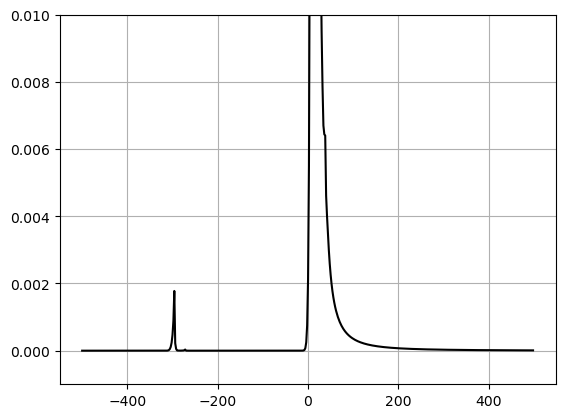

In [377]:
plt.plot(w*1e-3, rf, color = 'black')
plt.ylim([-0.001, 0.01])
plt.grid()
plt.show()